In [2]:
import numpy as np
from tqdm import tqdm

from src.data.preprocess_templates import *
from src.data.make_datasets import predict_ptp
from src.models.denoiser import SingleChanDenoiser
from src.evaluation.visualize import plot_templates

from spike_psvae.point_source_centering import relocate_simple

In [67]:
REPO_PATH = "/Users/johnzhou/research/spike-sorting"

clusters_fname = f"{REPO_PATH}/data/processed/clusters_k=20/templates.npy"
cluster_templates = np.load(clusters_fname)
print(cluster_templates.shape)
cluster_labels_fname = f"{REPO_PATH}/data/processed/clusters_k=20/unit_idxs.npy"
cluster_labels = np.load(cluster_labels_fname)
cluster_tens = torch.tensor(cluster_templates).float()

model = f"{REPO_PATH}/experiments/denoiser/single_chan_denoiser.pt"

geom_array = np.load(f"{REPO_PATH}/data/raw/channel_map_np2.npy")
n_channels = 20
channels_pos = geom_array[:n_channels]

(20000, 20, 121)


In [62]:
denoiser = SingleChanDenoiser()
denoiser.load(fname_model=model)

In [66]:
dn_clusters = np.zeros(cluster_templates.shape)
for i in tqdm(range(cluster_tens.shape[0])):
    dn_clusters[i, :, :] = denoiser.forward(cluster_tens[i, :, :]).detach().numpy()

100%|███████████████████████████████████| 20000/20000 [00:13<00:00, 1446.03it/s]


(1, 121, 20) (121, 20)
Template 0


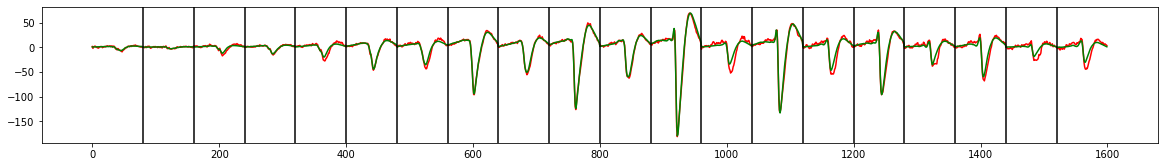

In [107]:
i = 10
sample = cluster_templates[i:i+1].swapaxes(1, 2)
dn_sample = dn_clusters[i].swapaxes(0, 1)
print(sample.shape, dn_sample.shape)

plot_templates(sample, base_template=dn_sample)

In [74]:
templates_chans, templates_ptp_chans = take_channel_range(dn_clusters, n_channels_loc=n_channels)
# Localize each template to a predicted position
template_positions = localize_wfs(templates_ptp_chans, geom_array)

100%|████████████████████████████████████| 20000/20000 [02:14<00:00, 148.77it/s]


In [81]:
print(templates_chans.shape, templates_ptp_chans.shape)
# print(templates_chans[0])
print(templates_ptp_chans[0])

(20000, 20, 20) (20000, 20)
[ 14.36351538  20.85663962  30.89410901  42.65270996  59.72283554
  81.05042076  94.85595894 138.91623211 160.23860288 155.76074457
 141.27030849 124.30263305 107.11405826  89.61395764  72.43101227
  56.86067748  44.55482554  33.3797352   23.5067426   14.4497509 ]


In [ ]:
wf_relocated, r, q = relocate_simple(templates, geom_array, )

In [97]:
def relocate_wfs(templates, template_positions, channel_positions, x=16, y=15, z_rel=0, alpha=150):
    
    n_samples, n_timesteps, n_channels = templates.shape
    new_templates = np.zeros(templates.shape)
    for i in tqdm(range(n_samples)):
        for j in range(channel_positions.shape[0]):
            predicted_ptp = predict_ptp(template_positions[i, :], channel_positions[j])
            template_z = template_positions[i, 2]
            new_predicted_ptp = predict_ptp(np.array([x, y, template_z + z_rel, alpha]), channel_positions[j])
            new_templates[i, :, j] = templates[i, :, j] * new_predicted_ptp / predicted_ptp

    return new_templates, new_templates.ptp(1)

In [98]:
reloc_dn_clusters = relocate_wfs(dn_clusters, template_positions, channels_pos)

100%|███████████████████████████████████| 20000/20000 [00:11<00:00, 1750.81it/s]


Template 0


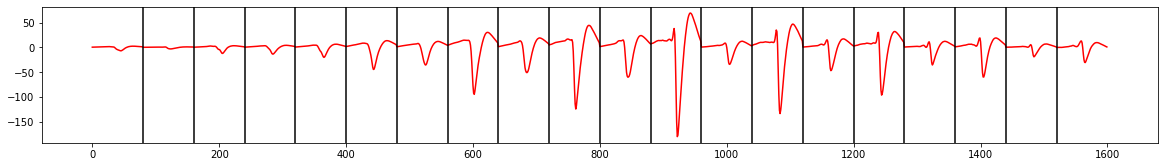

Template 0


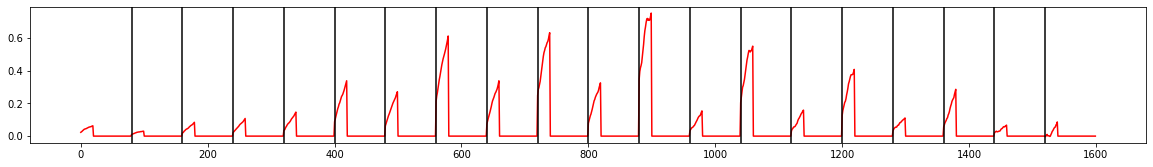

In [114]:
reloc_sample = reloc_dn_clusters[0][i:i+1].swapaxes(1, 2)
plot_templates(np.expand_dims(dn_sample, axis=0))
plot_templates(reloc_sample)